<a href="https://colab.research.google.com/github/preetham-v/antiviralGAN/blob/master/antiviral_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##SimpleGAN 

In [ ]:
#@title
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
url = 'https://raw.githubusercontent.com/preetham-v/antiviralGAN/master/AVPdb_data.csv'

data = pd.read_csv(url, skiprows = 1, usecols = range(3), header=None, names=['ID','seq','len'])

In [ ]:
all_sequences = np.asarray(data['seq'])
print(all_sequences[:5])

['PYVGSGLYRR' 'SMIENLEYM' 'ECRSTSYAGAVVNDL' 'STSYAGAVVNDL' 'YAGAVVNDL']


In [ ]:
#Dictionary of 20 canonical amino acids
CHARACTER_DICT = set([
    u'A', u'C', u'E', u'D', u'G', u'F', u'I', u'H', u'K',
    u'M', u'L', u'N', u'Q', u'P', u'S', u'R', u'T', u'W',
    u'V', u'Y']
)

CHARACTER_TO_INDEX = {
    character: i
    for i, character in enumerate(CHARACTER_DICT)
}

INDEX_TO_CHARACTER = {
    CHARACTER_TO_INDEX[c]: c
    for c in CHARACTER_TO_INDEX
}

In [ ]:
MAX_SEQUENCE_LENGTH = 18 #Problem Statement requires < 2000 kDa, Avg. amino acid = 110 kDa
num_amino_acids = len(CHARACTER_DICT) 

In [ ]:
def sequence_to_vector(sequence, embed_dict=None):
    if embed_dict==None:
        default = np.zeros([MAX_SEQUENCE_LENGTH, len(CHARACTER_TO_INDEX)+1])
        default[:,len(CHARACTER_TO_INDEX)] = 1
        for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
            default[i][CHARACTER_TO_INDEX[character]] = 1
            default[i][len(CHARACTER_TO_INDEX)] = 0
        return default
    else:
        default = np.zeros([MAX_SEQUENCE_LENGTH,len(embed_dict['A'])])
        for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
            for k,val in enumerate(embed_dict[character]):
                default[i,k] = val
        return default

In [ ]:
def vector_to_sequence(vector):
    seq = ''

    for i in range(18):
        arg = np.argmax(vector[i])
        if arg == 20:
          seq += 'X'
        else:
          seq += INDEX_TO_CHARACTER[arg]
    return seq


In [ ]:
class Generator(nn.Module):
    def __init__(self, input_length):
        """A generator for mapping a random peptide to an antiviral peptide
        Args:
            input_length (int array): max_length * number_of_characters 
                                      ("noise vector")
            layers (List[int]): A list of layer widths including output width
            output_activation: torch activation function or None
        """
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(input_length, 40)
        self.leaky_relu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(40, 120)
        self.linear3 = nn.Linear(120, 240)
        self.linear4 = nn.Linear(240, 378)
        self.output_activation = nn.LeakyReLU()

    def forward(self, input_tensor):
        """Forward pass; map latent vectors to samples."""
        intermediate = self.linear1(input_tensor)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.linear2(intermediate)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.linear3(intermediate)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.linear4(intermediate)
        intermediate = self.output_activation(intermediate)

        view = intermediate.view(-1, 18)
        (view == view.max(dim=1, keepdim=True)[0]).view_as(intermediate).int()
        
        return intermediate

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, layers):
        """A discriminator for discerning real from generated samples.
        params:
            input_dim (int): width of the input
            layers (List[int]): A list of layer widths including output width
        Output activation is Sigmoid.
        """
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self._init_layers(layers)

    def _init_layers(self, layers):
        """Initialize the layers and store as self.module_list."""
        self.module_list = nn.ModuleList()
        last_layer = self.input_dim
        for index, width in enumerate(layers):
            self.module_list.append(nn.Linear(last_layer, width))
            last_layer = width
            if index + 1 != len(layers):
                self.module_list.append(nn.LeakyReLU())
            else:
                self.module_list.append(nn.Sigmoid())

    def forward(self, input_tensor):
        """Forward pass; map samples to confidence they are real [0, 1]."""
        intermediate = input_tensor
        for layer in self.module_list:
            intermediate = layer(intermediate)
        return intermediate

In [ ]:
all_inputs = []
for j in range(len(all_sequences)):
  embedding = sequence_to_vector(all_sequences[j])
  all_inputs.append(np.reshape(embedding,378))

NameError: ignored

In [ ]:
def data_function(batch_size, iteration):
  input_array = all_inputs[batch_size*iteration : batch_size*(iteration+1)]
  return input_array

def noise_function(batch_size):
  input_array = np.random.randn(batch_size,1,20)
    # a = np.zeros([18,21])
    # for i in range(18):
    #   x = np.random.randint(21)
    #   a[i][x] = 1
    # input_array.append(np.reshape(a,378))
  
  return input_array

In [ ]:
#@title
class VanillaGAN():
    def __init__(self, generator, discriminator, noise_fn, data_fn,
                 batch_size=32, device='cpu', lr_d=1e-3, lr_g=2e-4):
        """A GAN class for holding and training a generator and discriminator
        Args:
            generator: a Ganerator network
            discriminator: A Discriminator network
            noise_fn: function f(num: int) -> pytorch tensor, (latent vectors)
            data_fn: function f(num: int) -> pytorch tensor, (real samples)
            batch_size: training batch size
            device: cpu or CUDA
            lr_d: learning rate for the discriminator
            lr_g: learning rate for the generator
        """
        self.generator = generator
        self.generator = self.generator.to(device)
        self.discriminator = discriminator
        self.discriminator = self.discriminator.to(device)
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.batch_size = batch_size
        self.device = device
        self.criterion = nn.BCELoss()
        self.optim_d = optim.Adam(discriminator.parameters(),
                                  lr=lr_d, betas=(0.5, 0.999))
        self.optim_g = optim.Adam(generator.parameters(),
                                  lr=lr_g, betas=(0.5, 0.999))
        self.target_ones = torch.ones((batch_size, 1)).to(device)
        self.target_zeros = torch.zeros((batch_size, 1)).to(device)

    def generate_samples(self, latent_vec=None, num=None):
        """Sample from the generator.
        Args:
            latent_vec: A pytorch latent vector or None
            num: The number of samples to generate if latent_vec is None
        If latent_vec and num are None then us self.batch_size random latent
        vectors.
        """
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
            samples = self.generator(latent_vec)
        return samples

    def train_step_generator(self):
        """Train the generator one step and return the loss."""
        self.generator.zero_grad()

        latent_vec = self.noise_fn(self.batch_size)
        generated = self.generator(latent_vec)
        classifications = self.discriminator(generated)
        loss = self.criterion(classifications, self.target_ones)
        loss.backward()
        self.optim_g.step()
        return loss.item()

    def train_step_discriminator(self):
        """Train the discriminator one step and return the losses."""
        self.discriminator.zero_grad()

        # real samples
        real_samples = self.data_fn(self.batch_size)
        pred_real = self.discriminator(real_samples)
        loss_real = self.criterion(pred_real, self.target_ones)

        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        with torch.no_grad():
            fake_samples = self.generator(latent_vec)
        pred_fake = self.discriminator(fake_samples)
        loss_fake = self.criterion(pred_fake, self.target_zeros)

        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_d.step()
        return loss_real.item(), loss_fake.item()

    def train_step(self):
        """Train both networks and return the losses."""
        loss_d = self.train_step_discriminator()
        loss_g = self.train_step_generator()
        return loss_g, loss_d

In [ ]:
def simpleGAN(generator_func, discriminator_func, 
              batch_size: int = 25, epochs: int = 5, 
              max_data: int = len(all_sequences), print_every: int = 10, ):

  #Array to monitor losses
  loss_g = []
  loss_dreal = []
  loss_dfake = []
  outputs = []
  input_length = 20

  # Models
  generator = generator_func
  discriminator = discriminator_func

  # Optimizers
  generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.01)
  discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), 
                                          lr=0.001)

  # loss
  loss = nn.BCELoss()

  for i in range(epochs):

    for j in range(int(max_data/batch_size)):

      # zero the gradients on each iteration
      generator_optimizer.zero_grad()


      # Create noisy input for generator
      # Need float type instead of int
      noise = noise_function(batch_size)
      noise_data = torch.tensor(noise).float()
      generated_data = generator(noise_data)  

      # Generate examples of real data
      true_data = data_function(batch_size, j)
      true_labels = torch.tensor(np.ones(batch_size)).float()
      true_data = torch.tensor(true_data).float()

      # Train the generator
      # We invert the labels here and don't train the discriminator because we want the generator
      # to make things the discriminator classifies as true.
      generator_discriminator_out = discriminator(generated_data)
      generator_loss = loss(generator_discriminator_out, true_labels)
      generator_loss.backward()
      generator_optimizer.step()

      # Train the discriminator on the true/generated data
      discriminator_optimizer.zero_grad()
      true_discriminator_out = discriminator(true_data)
      true_discriminator_loss = loss(true_discriminator_out, true_labels)

      # add .detach() here think about this
      generator_discriminator_out = discriminator(generated_data.detach())
      generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros(batch_size))
      discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2   
      discriminator_loss.backward()
      discriminator_optimizer.step()

      loss_g.append(generator_loss.detach().numpy())
      loss_dreal.append(true_discriminator_loss.detach().numpy())
      loss_dfake.append(generator_discriminator_loss.detach().numpy())
  

    
    generated_data = generated_data.detach().numpy()
#      x = random.randint(0,len(generated_data))
    sequences = set()
    
    for j in range(batch_size):
      sequence = np.reshape(generated_data[j], [18,21])
      sequences.add(vector_to_sequence(sequence))

    seq_update = list(sequences)
    outputs.append(seq_update)

    if i % print_every == 0:

      print("Currently at epoch: " + str(i))

  return loss_g, loss_dreal, loss_dfake, outputs



In [ ]:
#@title Default title text
def main():
    from time import time
    epochs = 600
    batches = 10
    generator = Generator(360)
    discriminator = Discriminator(1, [64, 32, 1])
    noise_fn = noise_function()
    data_fn = data_function()
    gan = VanillaGAN(generator, discriminator, noise_fn, data_fn, device='cpu')
    loss_g, loss_d_real, loss_d_fake = [], [], []
    start = time()
    for epoch in range(epochs):
        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for batch in range(batches):
            lg_, (ldr_, ldf_) = gan.train_step()
            loss_g_running += lg_
            loss_d_real_running += ldr_
            loss_d_fake_running += ldf_
        loss_g.append(loss_g_running / batches)
        loss_d_real.append(loss_d_real_running / batches)
        loss_d_fake.append(loss_d_fake_running / batches)
        print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
              f" G={loss_g[-1]:.3f},"
              f" Dr={loss_d_real[-1]:.3f},"
              f" Df={loss_d_fake[-1]:.3f}")


if __name__ == "__main__":
    main()

In [ ]:
import time

torch.manual_seed(1104)

start_time = time.time()

generator = Generator(20)
discriminator = Discriminator(378, [32, 16, 1])  

losses = simpleGAN(generator, discriminator, 
                   batch_size=2059, epochs=40000, print_every = 500)

outputs = losses[3]

print("Program took", time.time() - start_time, "to run")

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2059])) that is different to the input size (torch.Size([2059, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2059])) that is different to the input size (torch.Size([2059, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Currently at epoch: 0
Currently at epoch: 500
Currently at epoch: 1000
Currently at epoch: 1500
Currently at epoch: 2000
Currently at epoch: 2500
Currently at epoch: 3000
Currently at epoch: 3500
Currently at epoch: 4000
Currently at epoch: 4500
Currently at epoch: 5000
Currently at epoch: 5500
Currently at epoch: 6000
Currently at epoch: 6500
Currently at epoch: 7000
Currently at epoch: 7500
Currently at epoch: 8000
Currently at epoch: 8500
Currently at epoch: 9000
Currently at epoch: 9500
Currently at epoch: 10000
Currently at epoch: 10500
Currently at epoch: 11000
Currently at epoch: 11500
Currently at epoch: 12000
Currently at epoch: 12500
Currently at epoch: 13000
Currently at epoch: 13500
Currently at epoch: 14000
Currently at epoch: 14500
Currently at epoch: 15000
Currently at epoch: 15500
Currently at epoch: 16000
Currently at epoch: 16500
Currently at epoch: 17000
Currently at epoch: 17500
Currently at epoch: 18000
Currently at epoch: 18500
Currently at epoch: 19000
Currently 

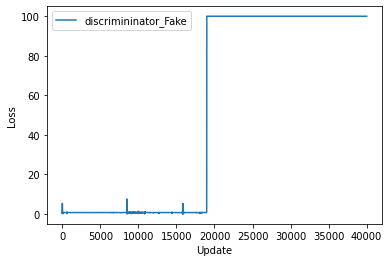

In [ ]:
loss_g = losses[0]
loss_dreal = losses[1]
loss_dfake = losses[2]
#plt.plot(loss_g, label = 'generator')
#plt.plot(loss_dreal, label ='discriminator_Real')
plt.plot(loss_dfake, label = 'discrimininator_Fake')
plt.xlabel('Update')
plt.ylabel('Loss')

plt.legend()

In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

KeyboardInterrupt: ignored

In [ ]:
with open('outputs.txt', 'w') as f:
    for item in outputs:
        f.write("%s\n" % item)

In [ ]:
from google.colab import files
files.download('outputs.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##NEW CODE - SeqGAN implementation

In [ ]:
#All dependencies 


from google.colab import files
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pdb
import math
import torch.nn.init as init
from math import ceil
import numpy as np
import sys
import torch.optim as optim
import pandas as pd
import re
import pickle

In [ ]:
#Download and extract Antiviral Sequences from AVPdb

MAX_SEQ_LEN = 18 #2000 kDa / 110 kDa = 18

url = 'https://raw.githubusercontent.com/preetham-v/antiviralGAN/master/AVPdb_data.csv'

data = pd.read_csv(url, skiprows = 1, usecols = range(3), header=None, names=['ID','seq','len'])

all_sequences = np.asarray(data['seq'])

#Two way dictionary of 20 canonical amino acids (not efficient, but helpful!)
CHARACTER_DICT = {
    'A': 1, 'C': 2, 'E': 3, 'D': 4, 'F': 5, 'I': 6, 'H': 7, 
    'K': 8, 'M': 9, 'L': 10, 'N': 11, 'Q': 12, 'P': 13, 'S': 14, 
    'R': 15, 'T': 16, 'W': 17, 'V': 18, 'Y': 19, 'G': 20}

INDEX_DICT = {
    1: 'A', 2: 'C', 3: 'E', 4: 'D', 5: 'F', 6: 'I', 7: 'H',
    8: 'K', 9: 'M', 10: 'L', 11: 'N', 12: 'Q', 13: 'P', 14: 'S',
    15: 'R', 16: 'T', 17: 'W', 18: 'V', 19: 'Y', 20: 'G', 21: 'X'}

<BarContainer object of 100 artists>

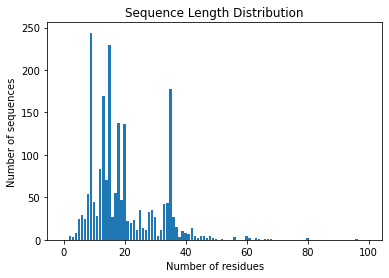

In [ ]:
#Checks for the distribution of sequences in Dataset

count = np.zeros(100)

for seq in all_sequences:
  count[len(seq)] += 1

plt.title('Sequence Length Distribution')
plt.xlabel('Number of residues')
plt.ylabel('Number of sequences')
plt.bar(np.arange(100), count)

In [ ]:
#Tokenises Sequence using dictionary above
def sequence_to_vector(sequence):

    default = np.asarray([21]*(MAX_SEQ_LEN))
    for i, character in enumerate(sequence[:MAX_SEQ_LEN]):
        default[i] = CHARACTER_DICT[character]
    return default.astype(int)

# Converts token vector to readable sequence
# Only token outside of INDEX_DICT possible is 0,
# and thus it will show up as 0 in sequence making it invalid

def vector_to_sequence(vector):
  
    return ''.join([INDEX_DICT.get(item, '0')  for item in vector])

In [ ]:
all_sequences = np.asarray(data['seq'])

all_data = []

for i in range(len(all_sequences)):

  all_data.append(sequence_to_vector(all_sequences[i]))

#Sanity check whether the data has been featurized properly
some_random_number = np.random.randint(len(all_sequences))
print(all_sequences[some_random_number])
print(all_data[some_random_number])
print(vector_to_sequence(all_data[some_random_number]))

RRKKAVALLPAVLLALLAP
[15 15  8  8  1 18  1 10 10 13  1 18 10 10  1 10 10  1]
RRKKAVALLPAVLLALLA


In [ ]:
class Generator(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, max_seq_len, gpu=False, oracle_init=False):
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size
        self.gpu = gpu

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim)
        self.gru2out = nn.Linear(hidden_dim, vocab_size)

        # initialise oracle network with N(0,1)
        # otherwise variance of initialisation is very small => high NLL for data sampled from the same model
        if oracle_init:
            for p in self.parameters():
                init.normal(p, 0, 1)

    def init_hidden(self, batch_size=1):
        h = autograd.Variable(torch.zeros(1, batch_size, self.hidden_dim))

        if self.gpu:
            return h.cuda()
        else:
            return h

    def forward(self, inp, hidden):
        """
        Embeds input and applies GRU one token at a time (seq_len = 1)
        """
        # input dim                                             # batch_size
        emb = self.embeddings(inp)                              # batch_size x embedding_dim
        emb = emb.view(1, -1, self.embedding_dim)               # 1 x batch_size x embedding_dim
        out, hidden = self.gru(emb, hidden)                     # 1 x batch_size x hidden_dim (out)
        out = self.gru2out(out.view(-1, self.hidden_dim))       # batch_size x vocab_size
        out = F.log_softmax(out, dim=1)
        return out, hidden

    def sample(self, num_samples, start_letter=0):
        """
        Samples the network and returns num_samples samples of length max_seq_len.
        Outputs: samples, hidden
            - samples: num_samples x max_seq_length (a sampled sequence in each row)
        """

        samples = torch.zeros(num_samples, self.max_seq_len).type(torch.LongTensor)

        h = self.init_hidden(num_samples)
        inp = autograd.Variable(torch.LongTensor([start_letter]*num_samples))

        if self.gpu:
            samples = samples.cuda()
            inp = inp.cuda()

        for i in range(self.max_seq_len):
            out, h = self.forward(inp, h)               # out: num_samples x vocab_size
            out = torch.multinomial(torch.exp(out), 1)  # num_samples x 1 (sampling from each row)
            samples[:, i] = out.view(-1).data

            inp = out.view(-1)

        return samples

    def batchNLLLoss(self, inp, target):
        """
        Returns the NLL Loss for predicting target sequence.
        Inputs: inp, target
            - inp: batch_size x seq_len
            - target: batch_size x seq_len
            inp should be target with <s> (start letter) prepended
        """

        loss_fn = nn.NLLLoss()
        batch_size, seq_len = inp.size()
        inp = inp.permute(1, 0)           # seq_len x batch_size
        target = target.permute(1, 0)     # seq_len x batch_size
        h = self.init_hidden(batch_size)

        loss = 0

        for i in range(seq_len):
            out, h = self.forward(inp[i], h)
            loss += loss_fn(out, target[i])

        return loss     # per batch

    def batchPGLoss(self, inp, target, reward):
        """
        Returns a pseudo-loss that gives corresponding policy gradients (on calling .backward()).
        Inspired by the example in http://karpathy.github.io/2016/05/31/rl/
        Inputs: inp, target
            - inp: batch_size x seq_len
            - target: batch_size x seq_len
            - reward: batch_size (discriminator reward for each sentence, applied to each token of the corresponding
                      sentence)
            inp should be target with <s> (start letter) prepended
        """

        batch_size, seq_len = inp.size()
        inp = inp.permute(1, 0)          # seq_len x batch_size
        target = target.permute(1, 0)    # seq_len x batch_size
        h = self.init_hidden(batch_size)

        loss = 0
        for i in range(seq_len):
            out, h = self.forward(inp[i], h)
            # TODO: should h be detached from graph (.detach())?
            for j in range(batch_size):
                loss += -out[j][target.data[i][j]]*reward[j]     # log(P(y_t|Y_1:Y_{t-1})) * Q

        return loss/batch_size

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, max_seq_len, gpu=False, dropout=0.2):
        super(Discriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.max_seq_len = max_seq_len
        self.gpu = gpu

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, bidirectional=True, dropout=dropout)
        self.gru2hidden = nn.Linear(2*2*hidden_dim, hidden_dim)
        self.dropout_linear = nn.Dropout(p=dropout)
        self.hidden2out = nn.Linear(hidden_dim, 1)

    def init_hidden(self, batch_size):
        h = autograd.Variable(torch.zeros(2*2*1, batch_size, self.hidden_dim))

        if self.gpu:
            return h.cuda()
        else:
            return h

    def forward(self, input, hidden):
        # input dim                                                # batch_size x seq_len
        emb = self.embeddings(input)                               # batch_size x seq_len x embedding_dim
        emb = emb.permute(1, 0, 2)                                 # seq_len x batch_size x embedding_dim
        _, hidden = self.gru(emb, hidden)                          # 4 x batch_size x hidden_dim
        hidden = hidden.permute(1, 0, 2).contiguous()              # batch_size x 4 x hidden_dim
        out = self.gru2hidden(hidden.view(-1, 4*self.hidden_dim))  # batch_size x 4*hidden_dim
        out = torch.tanh(out)
        out = self.dropout_linear(out)
        out = self.hidden2out(out)                                 # batch_size x 1
        out = torch.sigmoid(out)
        return out

    def batchClassify(self, inp):
        """
        Classifies a batch of sequences.
        Inputs: inp
            - inp: batch_size x seq_len
        Returns: out
            - out: batch_size ([0,1] score)
        """

        h = self.init_hidden(inp.size()[0])
        out = self.forward(inp, h)
        return out.view(-1)

    def batchBCELoss(self, inp, target):
        """
        Returns Binary Cross Entropy Loss for discriminator.
         Inputs: inp, target
            - inp: batch_size x seq_len
            - target: batch_size (binary 1/0)
        """

        loss_fn = nn.BCELoss()
        h = self.init_hidden(inp.size()[0])
        out = self.forward(inp, h)
        return loss_fn(out, target)

In [ ]:
def prepare_generator_batch(samples, start_letter=0, gpu=False):
    """
    Takes samples (a batch) and returns
    Inputs: samples, start_letter, cuda
        - samples: batch_size x seq_len (Tensor with a sample in each row)
    Returns: inp, target
        - inp: batch_size x seq_len (same as target, but with start_letter prepended)
        - target: batch_size x seq_len (Variable same as samples)
    """

    batch_size, seq_len = samples.size()

    inp = torch.zeros(batch_size, seq_len)
    target = samples
    inp[:, 0] = start_letter
    inp[:, 1:] = target[:, :seq_len-1]

    inp = inp.type(torch.LongTensor)
    target = target.type(torch.LongTensor)

    if gpu:
        inp = inp.cuda()
        target = target.cuda()

    return inp, target


def prepare_discriminator_data(pos_samples, neg_samples, gpu=False):
    """
    Takes positive (target) samples, negative (generator) samples and 
    prepares inp and target data for discriminator.
    Inputs: pos_samples, neg_samples
        - pos_samples: pos_size x seq_len
        - neg_samples: neg_size x seq_len
    Returns: inp, target
        - inp: (pos_size + neg_size) x seq_len
        - target: pos_size + neg_size (boolean 1/0)
    """

    inp = torch.cat((pos_samples, neg_samples), 0).type(torch.LongTensor)
    target = torch.ones(pos_samples.size()[0] + neg_samples.size()[0])
    target[pos_samples.size()[0]:] = 0

    # shuffle
    perm = torch.randperm(target.size()[0])
    target = target[perm]
    inp = inp[perm]

#    inp = Variable(inp)
#    target = Variable(target)

    if gpu:
        inp = inp.cuda()
        target = target.cuda()

    return inp, target


def batchwise_sample(gen, num_samples, batch_size):
    """
    Sample num_samples samples batch_size samples at a time from gen.
    Does not require gpu since gen.sample() takes care of that.
    """

    samples = []
    for i in range(int(ceil(num_samples/float(batch_size)))):
        samples.append(gen.sample(batch_size))

    return torch.cat(samples, 0)[:num_samples]

def batchwise_oracle_nll(gen, oracle, num_samples, batch_size, max_seq_len, start_letter=0, gpu=False):
    s = batchwise_sample(gen, num_samples, batch_size)
    oracle_nll = 0
    for i in range(0, num_samples, batch_size):
        inp, target = prepare_generator_batch(s[i:i+batch_size], start_letter, gpu)
        oracle_loss = oracle.batchNLLLoss(inp, target) / max_seq_len
        oracle_nll += oracle_loss.data.item()

    return oracle_nll/(num_samples/batch_size)

In [ ]:
def train_generator_MLE(gen, gen_opt, oracle, real_data_samples, epochs):
    """
    Max Likelihood Pretraining for the generator
    """
    for epoch in range(epochs):
        print('epoch %d : ' % (epoch + 1), end='')
        sys.stdout.flush()
        total_loss = 0

        for i in range(0, POS_NEG_SAMPLES, BATCH_SIZE):
            inp, target = prepare_generator_batch(real_data_samples[i:i + BATCH_SIZE], start_letter=START_LETTER,
                                                          gpu=CUDA)
            gen_opt.zero_grad()
            loss = gen.batchNLLLoss(inp, target)
            loss.backward()
            gen_opt.step()

            total_loss += loss.data.item()

            if (i / BATCH_SIZE) % ceil(
                            ceil(POS_NEG_SAMPLES / float(BATCH_SIZE)) / 10.) == 0:  # roughly every 10% of an epoch
                print('.', end='')
                sys.stdout.flush()

        # each loss in a batch is loss per sample
        total_loss = total_loss / ceil(POS_NEG_SAMPLES / float(BATCH_SIZE)) / MAX_SEQ_LEN

        # sample from generator and compute oracle NLL
        oracle_loss = batchwise_oracle_nll(gen, oracle, POS_NEG_SAMPLES, BATCH_SIZE, MAX_SEQ_LEN,
                                                   start_letter=START_LETTER, gpu=CUDA)
        
        loss_g.append(oracle_loss)

        print(' average_train_NLL = %.4f, oracle_sample_NLL = %.4f' % (total_loss, oracle_loss))


def train_generator_PG(gen, gen_opt, oracle, dis, num_batches):
    """
    The generator is trained using policy gradients, using the reward from the discriminator.
    Training is done for num_batches batches.
    """

    for batch in range(num_batches):
        s = gen.sample(BATCH_SIZE*2)        # 64 works best
        inp, target = prepare_generator_batch(s, start_letter=START_LETTER, gpu=CUDA)
        rewards = dis.batchClassify(target)

        gen_opt.zero_grad()
        pg_loss = gen.batchPGLoss(inp, target, rewards)
        pg_loss.backward()
        gen_opt.step()

    # sample from generator and compute oracle NLL
    oracle_loss = batchwise_oracle_nll(gen, oracle, POS_NEG_SAMPLES, BATCH_SIZE, MAX_SEQ_LEN,
                                                   start_letter=START_LETTER, gpu=CUDA)

    loss_g.append(oracle_loss)
    
    print(' oracle_sample_NLL = %.4f' % oracle_loss)


In [ ]:
def train_discriminator(discriminator, dis_opt, real_data_samples, generator, oracle, d_steps, epochs):
    """
    Training the discriminator on real_data_samples (positive) and generated samples from generator (negative).
    Samples are drawn d_steps times, and the discriminator is trained for epochs epochs.
    """

    # generating a small validation set before training (using oracle and generator)
    pos_val = oracle.sample(100)
    neg_val = generator.sample(100)
    val_inp, val_target = prepare_discriminator_data(pos_val, neg_val, gpu=CUDA)

    for d_step in range(d_steps):
        s = batchwise_sample(generator, POS_NEG_SAMPLES, BATCH_SIZE)
#        print(s.shape, real_data_samples.shape)
        dis_inp, dis_target = prepare_discriminator_data(real_data_samples, s, gpu=CUDA)
        for epoch in range(epochs):
            print('d-step %d epoch %d : ' % (d_step + 1, epoch + 1), end='')
            sys.stdout.flush()
            total_loss = 0
            total_acc = 0

            for i in range(0, 2 * POS_NEG_SAMPLES, BATCH_SIZE): #2 * POS_NEG_SAMPLES because both pos 
                                                                #and neg samples included in dis_inp
                inp, target = dis_inp[i:i + BATCH_SIZE], dis_target[i:i + BATCH_SIZE]
                dis_opt.zero_grad()
                out = discriminator.batchClassify(inp)
                loss_fn = nn.BCELoss()
                loss = loss_fn(out, target)
                loss.backward()
                dis_opt.step()

                total_loss += loss.data.item()
                total_acc += torch.sum((out>0.5)==(target>0.5)).data.item()

                if (i / BATCH_SIZE) % ceil(ceil(2 * POS_NEG_SAMPLES / float(
                        BATCH_SIZE)) / 10.) == 0:  # roughly every 10% of an epoch
                    print('.', end='')
                    sys.stdout.flush()

            total_loss /= ceil(2 * POS_NEG_SAMPLES / float(BATCH_SIZE))
            total_acc /= float(2 * POS_NEG_SAMPLES)

            val_pred = discriminator.batchClassify(val_inp)
            print(' average_loss = %.4f, train_acc = %.4f, val_acc = %.4f' % (
                total_loss, total_acc, torch.sum((val_pred>0.5)==(val_target>0.5)).data.item()/200.))
            
            loss_d.append(total_loss)


In [ ]:
CUDA = True

#Fixed Params
VOCAB_SIZE = 22 #Starting Letter + 20 AA + Padding
MAX_SEQ_LEN = 18 #2000 kDa / 110 kDa = 18
START_LETTER = 0 
POS_NEG_SAMPLES = len(all_data) #Size of AVPDb dataset
torch.manual_seed(11)

#Variables
BATCH_SIZE = 512 
ADV_TRAIN_EPOCHS = 100 

#Generator Parameters
MLE_TRAIN_EPOCHS = 100
GEN_EMBEDDING_DIM = 3
GEN_HIDDEN_DIM = 32
NUM_PG_BATCHES = 1
GEN_lr = 1e-1

#Discriminator Parameters
DIS_EMBEDDING_DIM = 5            
DIS_HIDDEN_DIM = 32
D_STEPS = 50
D_EPOCHS = 2
ADV_D_EPOCHS = 3
ADV_D_STEPS = 5



In [ ]:
#Used to store output of cell

# MAIN
if __name__ == '__main__':

    # a new oracle can be generated by passing oracle_init=True in the generator constructor
    oracle = Generator(GEN_EMBEDDING_DIM, GEN_HIDDEN_DIM, VOCAB_SIZE, MAX_SEQ_LEN, gpu=CUDA, oracle_init=True)

    #Initialize Generator and Discriminator
    gen = Generator(GEN_EMBEDDING_DIM, GEN_HIDDEN_DIM, VOCAB_SIZE, MAX_SEQ_LEN, gpu=CUDA)
    dis = Discriminator(DIS_EMBEDDING_DIM, DIS_HIDDEN_DIM, VOCAB_SIZE, MAX_SEQ_LEN, gpu=CUDA)

    loss_g = []
    loss_d = []

    if CUDA:
      oracle = oracle.cuda()
      gen = gen.cuda()
      dis = dis.cuda()
#      oracle_samples = oracle_samples.cuda()

    #Converts Vectorized Inputs to Tensor
    oracle_samples = torch.Tensor(all_data).cuda()

    # GENERATOR MLE TRAINING
    print('Starting Generator MLE Training...')
    gen_optimizer = optim.Adam(gen.parameters(), lr = GEN_lr)
    train_generator_MLE(gen, gen_optimizer, oracle, torch.Tensor(all_data), MLE_TRAIN_EPOCHS)

    # torch.save(gen.state_dict(), pretrained_gen_path)
    # gen.load_state_dict(torch.load(pretrained_gen_path))

    # PRETRAIN DISCRIMINATOR
    print('\nStarting Discriminator Training...')
    dis_optimizer = optim.Adagrad(dis.parameters())
    train_discriminator(dis, dis_optimizer, oracle_samples, gen, oracle, D_STEPS, D_EPOCHS)

    # ADVERSARIAL TRAINING
    print('\nStarting Adversarial Training...')
    oracle_loss = batchwise_oracle_nll(gen, oracle, POS_NEG_SAMPLES, BATCH_SIZE, MAX_SEQ_LEN,
                                               start_letter=START_LETTER, gpu=CUDA)
    print('\nInitial Oracle Sample Loss : %.4f' % oracle_loss)

    for epoch in range(ADV_TRAIN_EPOCHS):
        print('\n--------\nEPOCH %d\n--------' % (epoch+1))
        # TRAIN GENERATOR
        print('\nAdversarial Training Generator : ', end='')
        sys.stdout.flush()
        train_generator_PG(gen, gen_optimizer, oracle, dis, NUM_PG_BATCHES)

        # TRAIN DISCRIMINATOR
        print('\nAdversarial Training Discriminator : ')
        train_discriminator(dis, dis_optimizer, oracle_samples, gen, oracle, ADV_D_STEPS, ADV_D_EPOCHS)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


Starting Generator MLE Training...
epoch 1 : ..... average_train_NLL = 3.3153, oracle_sample_NLL = 10.0874
epoch 2 : ..... average_train_NLL = 2.5697, oracle_sample_NLL = 10.8635
epoch 3 : ..... average_train_NLL = 2.3919, oracle_sample_NLL = 10.4072
epoch 4 : ..... average_train_NLL = 2.2985, oracle_sample_NLL = 10.2430
epoch 5 : ..... average_train_NLL = 2.2501, oracle_sample_NLL = 10.5561
epoch 6 : ..... average_train_NLL = 2.2094, oracle_sample_NLL = 10.8182
epoch 7 : ..... average_train_NLL = 2.1662, oracle_sample_NLL = 10.1169
epoch 8 : ..... average_train_NLL = 2.1466, oracle_sample_NLL = 10.5022
epoch 9 : ..... average_train_NLL = 2.1366, oracle_sample_NLL = 10.8195
epoch 10 : ..... average_train_NLL = 2.1125, oracle_sample_NLL = 10.2257
epoch 11 : ..... average_train_NLL = 2.0597, oracle_sample_NLL = 10.8130
epoch 12 : ..... average_train_NLL = 2.0222, oracle_sample_NLL = 10.4392
epoch 13 : ..... average_train_NLL = 2.0135, oracle_sample_NLL = 10.6219
epoch 14 : ..... average_

In [ ]:
#Sample sequences from the Generator

#gen = Generator(GEN_EMBEDDING_DIM, GEN_HIDDEN_DIM, VOCAB_SIZE, MAX_SEQ_LEN, gpu=False)
#dis = Discriminator(DIS_EMBEDDING_DIM, DIS_HIDDEN_DIM, VOCAB_SIZE, MAX_SEQ_LEN, gpu=False)

#gen.cuda()
#dis.cuda()

#gen.load_state_dict(torch.load('/content/gen.pth',  map_location=torch.device('cpu')))
#dis.load_state_dict(torch.load('/content/dis.pth',  map_location=torch.device('cpu')))

#gen.eval()
dis.eval()

num_seqs = 25

a = gen.sample(num_seqs).tolist()

for i in range(num_seqs):
  seq = (vector_to_sequence(a[i]))
  seq = re.sub('[X]+$', '', seq)
  check_x = re.search('[X]', seq)
  if check_x:
    print(seq + ', Invalid')
  else:
    print(">pep" + str(i))
    print(seq)


>pep0
ALGANLNAMVYGVYAACG
>pep1
AYTHDAGVGA
>pep2
RRKKALTGTAAAFFF
>pep3
SARRYPLRRAKRGGAR
>pep4
TPGA
>pep5
DVDAYDAVQITENKPLSD
>pep6
AFLLGTNQSLIF
>pep7
YWEDFFEFFKHFVRR
>pep8
KKKKVVAATYFFF
>pep9
DVTVQVTVCAVAALEALG
>pep10
WALNTRHYVH
>pep11
RNTVNLAELGKIGAIMLS
>pep12
GQWVV
>pep13
KKKKVLAFLYFSSA
>pep14
KDPAVLFPAAKLLKKAAG
>pep15
KKKKLVLPFLLF
>pep16
KKKKVLATLCF
>pep17
AGTPKFLRLK
>pep18
GLRLQGTAPNLGTYPKYY
>pep19
LPAAIDQRLDWIELNLEE
>pep20
QGTWRPGFLGFPFFFKVK
>pep21
ILMCCSVDP
>pep22
AESGDPRAVLLRVGYEVS
>pep23
KKKLVLSTYFFYSPYWWA
>pep24
ASGIGRNKFQKQIARGTM


In [ ]:
#Writes output of main() cell to file 
#which can be downloaded if needed

with open('losses.txt', 'w') as f:
    f.write(cap.stdout)

Download = True

if Download:
  files.download('losses.txt') 



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
file1 = open('losses.txt', 'r') 
lines = file1.readlines() 

loss_g = []
loss_d = []

for line in lines:

  reg_lossg = re.search('oracle_sample_NLL = ([-+]?[0-9]*\.?[0-9]+)', line)
  reg_lossd = re.search('average_loss = ([-+]?[0-9]*\.?[0-9]+)', line)  
  if reg_lossg:
    loss_g.append(float(reg_lossg.group(1)))
  if reg_lossd:
    loss_d.append(float(reg_lossd.group(1)))

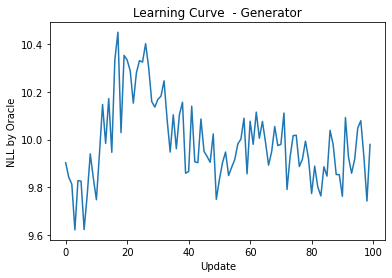

In [ ]:
#Which loss to plot? 'g' = Generator, 'd' = Discriminator

plt_loss = 'g'

if plt_loss == 'g':
  plt.title('Learning Curve  - Generator')
  plt.ylabel('NLL by Oracle')
  plt.xlabel('Update')
  plt.plot(loss_g[100:])

if plt_loss == 'd':
  plt.title('Learning Curve - Discriminator')
  plt.ylabel('BCE Loss')
  plt.xlabel('Update')
  plt.plot(loss_d)

In [ ]:
#Save the Models

torch.save(gen.state_dict(), '/content/gen.pth')
torch.save(dis.state_dict(), '/content/dis.pth')

#Load the Models
# model = Generator(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()


In [ ]:
files.download('dis.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# gen = Generator(GEN_EMBEDDING_DIM, GEN_HIDDEN_DIM, VOCAB_SIZE, MAX_SEQ_LEN, gpu=True)
# dis = Discriminator(DIS_EMBEDDING_DIM, DIS_HIDDEN_DIM, VOCAB_SIZE, MAX_SEQ_LEN, gpu=True)

# gen.cuda()
# dis.cuda()

# gen.load_state_dict(torch.load('/content/gen.pth'))
# dis.load_state_dict(torch.load('/content/dis.pth'))

# gen.eval()
# dis.eval()

print('\nStarting Adversarial Training...')
oracle_loss = batchwise_oracle_nll(gen, oracle, POS_NEG_SAMPLES, BATCH_SIZE, MAX_SEQ_LEN,
                                            start_letter=START_LETTER, gpu=CUDA)
print('\nInitial Oracle Sample Loss : %.4f' % oracle_loss)

loss_frozen = []

for epoch in range(100):
    print('\n--------\nEPOCH %d\n--------' % (epoch+1))
    # TRAIN GENERATOR
    print('\nAdversarial Training Generator : ', end='')
    sys.stdout.flush()
    train_generator_PG(gen, gen_optimizer, oracle, dis, 1)

    TRAIN DISCRIMINATOR
   print('\nSkkipping adversarial Training Discriminator : ')
   train_discriminator(dis, dis_optimizer, oracle_samples, gen, oracle, ADV_D_STEPS, ADV_D_EPOCHS)

Discriminator(
  (embeddings): Embedding(22, 3)
  (gru): GRU(3, 32, num_layers=2, dropout=0.2, bidirectional=True)
  (gru2hidden): Linear(in_features=128, out_features=32, bias=True)
  (dropout_linear): Dropout(p=0.2, inplace=False)
  (hidden2out): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
def noise():
  print("AAAAAAAHHHH")

a = noise()

print(a)

AAAAAAAHHHH
None
